In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz 

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree



In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
NumPy 1.18.1
SciPy 1.4.1
Scikit-Learn 0.22.1


In [6]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

In [4]:
df_Alagoas = pd.read_csv('../microdadosEnemAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_Alagoas =  df_Alagoas.loc[:, ~df_Alagoas.columns.str.contains('^Unnamed')]
df_Alagoas

,NU_INSCRICAO,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008411121,AL,19.0,1.0,0.0,3.0,1.0,1.0,0.0,442.4,...,A,B,B,A,B,A,B,B,A,A
1,180008788016,AL,40.0,0.0,2.0,3.0,6.0,1.0,0.0,393.8,...,A,B,B,A,B,A,A,B,A,A
2,180008411503,AL,24.0,1.0,0.0,3.0,7.0,1.0,0.0,449.5,...,B,B,B,A,B,A,A,B,A,C
3,180008257102,AL,28.0,0.0,0.0,3.0,8.0,1.0,0.0,478.5,...,A,B,A,A,D,A,A,B,A,A
4,180008309661,AL,17.0,1.0,0.0,3.0,0.0,1.0,0.0,594.7,...,A,C,B,A,C,A,A,A,B,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64600,180013469026,AL,34.0,1.0,0.0,3.0,0.0,1.0,0.0,410.0,...,A,B,A,B,B,B,B,A,A,A
64601,180013985741,AL,20.0,0.0,0.0,3.0,2.0,1.0,0.0,413.0,...,A,B,A,A,B,A,A,B,A,A
64602,180013955750,AL,18.0,1.0,0.0,3.0,0.0,2.0,0.0,491.1,...,A,A,A,A,B,A,A,A,B,A
64603,180013983882,AL,18.0,1.0,0.0,2.0,0.0,1.0,0.0,471.0,...,A,B,B,A,C,A,B,B,B,B


# Variável alvo é a nota de matematica dos participantes

In [5]:
# feature-cols vai armazenar todas as colunas exceto a coluna que armazena as
# notas de matemática do participante de Alagoas
feature_cols = [x for x in df_Alagoas.columns if x != 'NU_NOTA_MT']
X = df_Alagoas[feature_cols]
Y = df_Alagoas['NU_NOTA_MT']



In [6]:
df_Alagoas.shape

(64605, 41)

In [6]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
#test-size = 0.3 define que o tamanho da base de teste é de 30% da base principal, e a base de treino é 70%

#visualizando os tamanhos da bases, teino e teste
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


# Pré-processamento

In [7]:
#dataframe que irá receber a resposta dada pelo sistema
df_resposta = pd.DataFrame()

#dataframe que guarda a nota orginal obtida pelo participante
df_resposta['NU_INSCRICAO'] = X_test['NU_INSCRICAO']
df_resposta['NU_NOTA_MT'] = y_test

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO',  'Q005']

numeric_transformer = Pipeline(   steps=[ ('scaler', StandardScaler())])

categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]

preprocessing = ColumnTransformer(transformers=[
                                        ('num', numeric_transformer, numeric_features),                                       
                                        ('cat', categorical_transformer, categorical_features),  
])

In [9]:
feature_names= numeric_features + categorical_features
len(feature_names)
print(feature_names)

['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q005', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']


# Aplicando o regressor

## Random Forest

In [10]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [11]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
#y_pred = rf.predict(X_test)



#print(y_pred)

RF train accuracy: 0.893
RF test accuracy: 0.402


## Regressão Linear

In [ ]:
lr =  Pipeline([
    ('preprocess', preprocessing),
    ('regressor', LinearRegression())
])
lr.fit(X_train, y_train)

In [12]:
# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % lr.score(X_train, y_train))
print("RN test R²: %0.3f" % lr.score(X_test, y_test))

RN train R²: 0.438
RN test R²: 0.438


## Rede neural

In [ ]:
rn = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50, 50),tol=1e-2,max_iter=500, random_state=0))
])
rn.fit(X_train, y_train)

In [18]:
# score = Return the coefficient of determination R^2 of the prediction
print("RN train R²: %0.3f" % rn.score(X_train, y_train))
print("RN test R²: %0.3f" % rn.score(X_test, y_test))

RN train R²: 0.485
RN test R²: 0.461


# Árvore de decisão

In [18]:
dtree = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [14]:
# # score = Return the coefficient of determination R^2 of the prediction
print("Coefficient of determination R² of the prediction train.: %0.3f" % dtree.score(X_train, y_train))
print("Coefficient of determination R² of the prediction test: %0.3f" % dtree.score(X_test, y_test))
#x = dtree.named_steps['regressor'].feature_importances_

Coefficient of determination R² of the prediction train.: 1.000
Coefficient of determination R² of the prediction test: -0.112


In [15]:
#df_resposta['NU_NOTA_MT_predRF'] = y_pred
df_metricas = pd.DataFrame()
df_resposta.shape

df_features_importance =  pd.DataFrame()


In [16]:
def GuardaFeatures(clf, label):
    
    df_features_importance[label] = clf.named_steps['regressor'].feature_importances_
            
    ohe                           = (clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'])
            
    feature_names                 = ohe.get_feature_names(input_features=categorical_features)
            
    df_features_importance['feature_names' + label] =  np.r_[feature_names, numeric_features] 
    

# Aplicando os regressores

In [17]:
import time
scorings=['r2']

clfs = [rf, lr, rn, dtree]
start_time = time.time()
valores=[]
i=0
for clf, label in zip(clfs, ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']):
    
        tempro_processamento = time.time()
        
        print( "Processando o modelo: [%s]" % label)
        
       # cv = cross_validate(clf, X_train, y_train, cv=5,  n_jobs=-1, verbose=0, return_train_score=True)        
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        
        y_pred = cross_val_predict(clf, X_test, y_test, n_jobs=-1, verbose=0)     
        
        df_resposta['NU_NOTA_MT_'+ label] = y_pred
        
        df_metricas['Modelo']                    = ['Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']
        
        df_metricas.loc[i,'Max_Error']           = round(max_error(y_test, y_pred), 2)
        df_metricas.loc[i,'MAE']                 = round(mean_absolute_error(y_test, y_pred), 2)         
        df_metricas.loc[i,'R²']                  = round(r2_score(y_test, y_pred), 2)
        df_metricas.loc[i,'MSE']                 = round(mean_squared_error(y_test, y_pred), 2)
        df_metricas.loc[i,'CV scores mean']      = round(cv_scores.mean(), 2)
        df_metricas.loc[i,'CV scores std']       = round(cv_scores.std(), 2)
          
        
      
        if(label == "Random Forest"):
           
            GuardaFeatures(clf, label)
           
        elif(label == "Árvore de decisão"):
            
            GuardaFeatures(clf, label)
            
            
        tempo = (time.time() - tempro_processamento)
        tempoMinutos =  tempo/60  
        df_metricas.loc[i, 'Tempo de processamento min'] = round( tempoMinutos, 2)
        
        print("Tempo de processamento [%s] em minutos: %f  " %( label, round( tempoMinutos, 2) ) )
        print('\n')
        i+=1
       
        #print("Accuracy: %0.2f (+/- %0.2f) [%s]" % ( cv_scores.mean(),  cv_scores.std(), label))
        
       
    
    
elapsed_time = time.time() - start_time

print("tempo de processamento total em minutos:" , (round(elapsed_time/60, 2)))
print('Processamento finalizado')
#print(elapsed_time)

Processando o modelo: [Random Forest]
Tempo de processamento [Random Forest] em minutos: 9.010000  


Processando o modelo: [Regressão Linear]
Tempo de processamento [Regressão Linear] em minutos: 0.290000  


Processando o modelo: [Rede Neural]


C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Tempo de processamento [Rede Neural] em minutos: 20.200000  


Processando o modelo: [Árvore de decisão]
Tempo de processamento [Árvore de decisão] em minutos: 2.190000  


tempo de processamento total em minutos: 31.69
Processamento finalizado


# Transformando para float 64 e com uma casa decimal

In [19]:

df_resposta[['NU_NOTA_MT_Random Forest','NU_NOTA_MT_Regressão Linear','NU_NOTA_MT_Rede Neural']]= df_resposta[['NU_NOTA_MT_Random Forest','NU_NOTA_MT_Regressão Linear','NU_NOTA_MT_Rede Neural' ]].applymap("{0:.1f}".format).astype('float64')



In [20]:
df_metricas


,Modelo,Max_Error,MAE,R²,MSE,CV scores mean,CV scores std,Tempo de processamento min
0,Random Forest,485.11,58.77,0.40,5428.39,0.40,0.01,9.01
1,Regressão Linear,513.67,57.01,0.44,5072.02,0.43,0.01,0.29
2,Rede Neural,499.38,55.96,0.45,4965.24,0.45,0.02,20.20
3,Árvore de decisão,647.80,78.71,-0.12,10057.61,-0.11,0.01,2.19


# Salvando os dataframes com os resultados

In [21]:
#Salvar num arquivo csv o dataframe com os dados de Alagoas

df_resposta.to_csv('microdadosRespostaAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_features_importance.to_csv('microdadosFeaturesImportancesAL.csv', sep = ';', encoding='ISO 8859-1')
df_metricas.to_csv('microdadosMetricasAL.csv', sep = ';', encoding='ISO 8859-1')

# Features Importances - Ramdom Forest - Alagoas

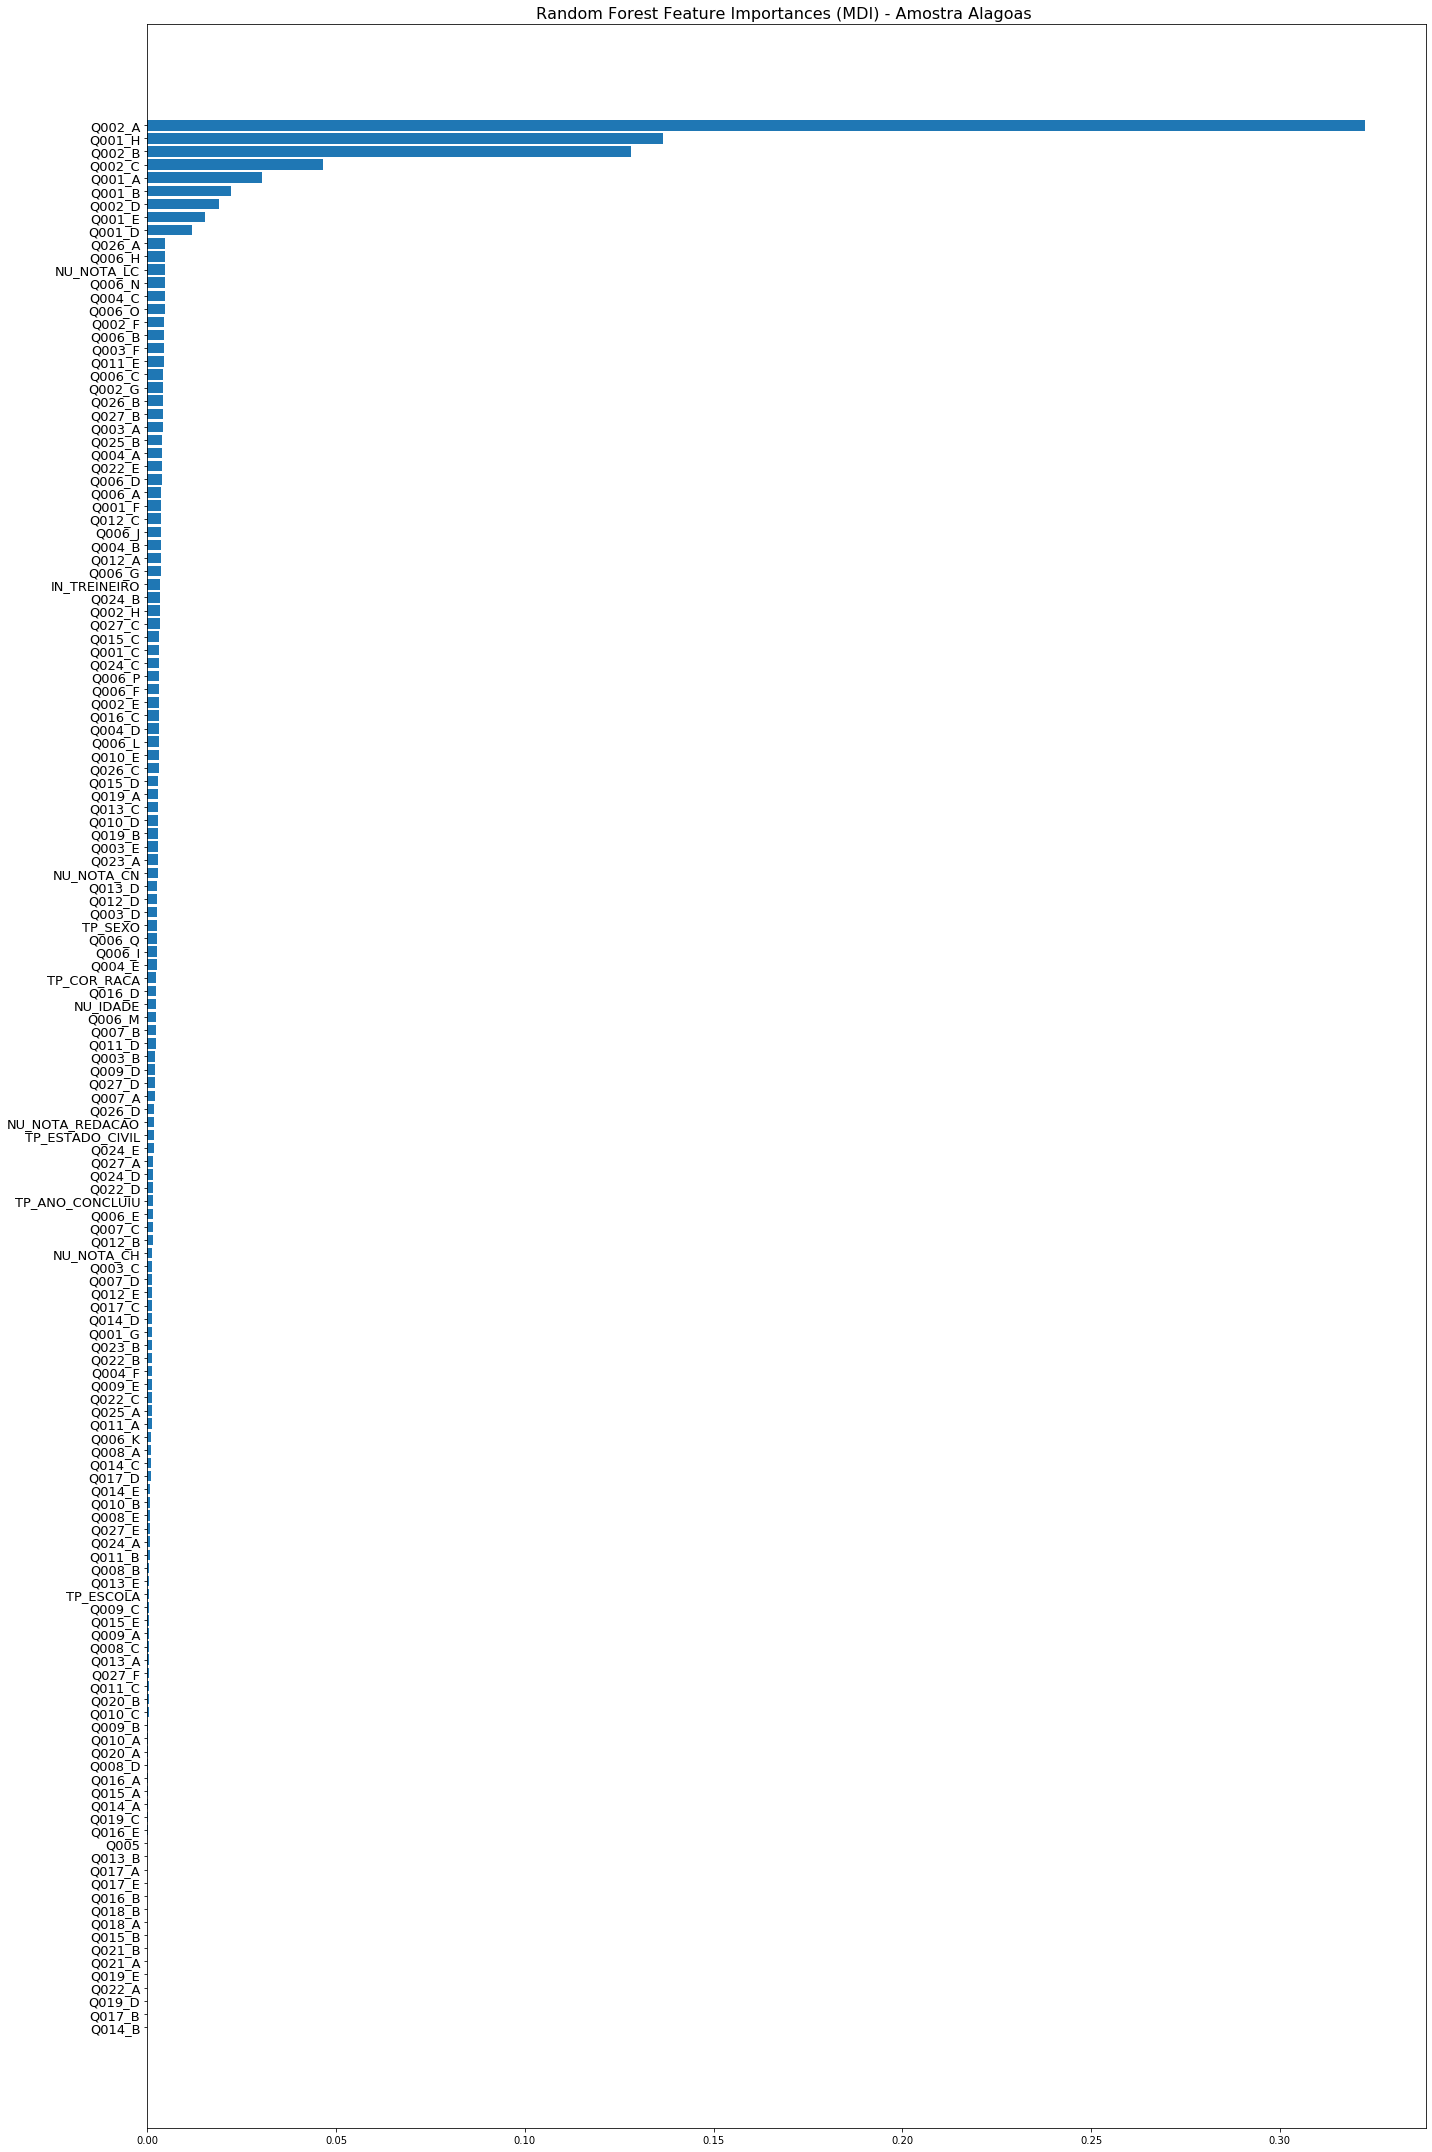

In [23]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 30))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances - Amostra Alagoas - Matemática ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_AL_MT.png', format='png')
plt.show()

In [165]:
df_RF = pd.DataFrame()
df_DT = pd.DataFrame()

In [166]:

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

features_importance = zip(tree_feature_importances, feature_names)

print()
labels = []
importances = []
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100))  

df_RF['importances RF'] = importances
df_RF['features'] = labels

print(importances, labels)


Q002_A: 32.250137%
Q001_H: 13.654667%
Q002_B: 12.810070%
Q002_C: 4.650045%
Q001_A: 3.032966%
Q001_B: 2.226458%
Q002_D: 1.906226%
Q001_E: 1.515700%
Q001_D: 1.175537%
Q026_A: 0.479403%
Q006_H: 0.479238%
NU_NOTA_LC: 0.476733%
Q006_N: 0.473867%
Q004_C: 0.465314%
Q006_O: 0.464333%
Q002_F: 0.452279%
Q006_B: 0.449188%
Q003_F: 0.445014%
Q011_E: 0.428966%
Q006_C: 0.421206%
Q002_G: 0.419505%
Q026_B: 0.411525%
Q027_B: 0.404151%
Q003_A: 0.403330%
Q025_B: 0.388576%
Q004_A: 0.385214%
Q022_E: 0.380185%
Q006_D: 0.378373%
Q006_A: 0.372048%
Q001_F: 0.369369%
Q012_C: 0.364448%
Q006_J: 0.364350%
Q004_B: 0.358528%
Q012_A: 0.352243%
Q006_G: 0.350929%
IN_TREINEIRO: 0.343461%
Q024_B: 0.341261%
Q002_H: 0.333478%
Q027_C: 0.324181%
Q015_C: 0.322824%
Q001_C: 0.320990%
Q024_C: 0.320702%
Q006_P: 0.316099%
Q006_F: 0.315374%
Q002_E: 0.309685%
Q016_C: 0.303652%
Q004_D: 0.303635%
Q006_L: 0.302231%
Q010_E: 0.301891%
Q026_C: 0.298958%
Q015_D: 0.296403%
Q019_A: 0.293760%
Q013_C: 0.292363%
Q010_D: 0.284609%
Q019_B: 0.2793

In [168]:

ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

features_importance = zip(tree_feature_importances, feature_names)

print()
labels = []
importances = []
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100))  

df_DT['importances DT'] = importances
df_DT['features'] = labels

print(importances, labels)


Q002_A: 32.355838%
Q001_H: 13.582338%
Q002_B: 12.302095%
Q002_C: 4.318153%
Q001_A: 3.127673%
Q001_B: 2.201698%
Q002_D: 1.871650%
Q001_E: 1.417812%
Q001_D: 1.203921%
Q006_N: 0.537455%
Q003_A: 0.488158%
Q025_B: 0.459718%
Q006_H: 0.454963%
Q004_C: 0.453506%
Q002_F: 0.452446%
Q003_F: 0.445501%
Q006_C: 0.439890%
Q026_A: 0.436991%
Q006_G: 0.425037%
Q004_A: 0.422962%
Q027_C: 0.419835%
Q006_J: 0.414354%
Q026_B: 0.404430%
Q011_E: 0.403243%
Q006_O: 0.402931%
Q012_A: 0.402347%
NU_NOTA_LC: 0.400459%
Q006_B: 0.399480%
Q002_H: 0.389745%
Q002_G: 0.386140%
Q006_P: 0.384077%
Q004_B: 0.380778%
Q027_B: 0.370894%
Q010_D: 0.365618%
Q006_F: 0.364376%
Q024_C: 0.363681%
Q026_C: 0.360888%
Q006_D: 0.359218%
Q006_A: 0.357270%
Q001_F: 0.354412%
Q012_C: 0.344168%
Q016_D: 0.342202%
Q009_D: 0.336627%
Q013_C: 0.334289%
IN_TREINEIRO: 0.331764%
Q019_B: 0.328199%
Q015_C: 0.320794%
Q022_E: 0.306200%
Q001_C: 0.305265%
Q024_B: 0.303418%
Q002_E: 0.301638%
Q012_D: 0.300359%
Q015_D: 0.298784%
Q003_D: 0.296901%
Q010_E: 0.2968

In [167]:
df_RF

,importances RF,features
0,32.25,Q002_A
1,13.65,Q001_H
2,12.81,Q002_B
3,4.65,Q002_C
4,3.03,Q001_A
...,...,...
141,0.00,Q019_E
142,0.00,Q022_A
143,0.00,Q019_D
144,0.00,Q017_B


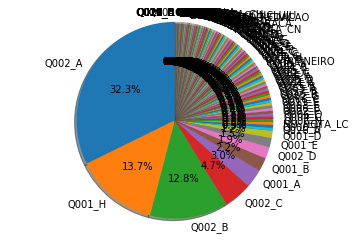

In [174]:
fig1, ax1 = plt.subplots()
ax1.pie(df_RF['importances RF'], labels=df_RF['features'], autopct='%1.1f%%',  shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

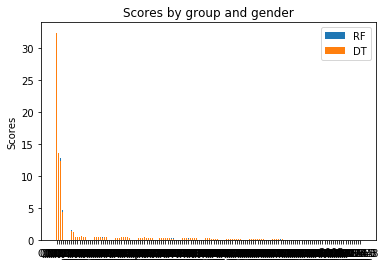

In [179]:
import numpy as np
import matplotlib.pyplot as plt


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(df_RF['features'], df_RF['importances RF'], width,  label='RF')
ax.bar(df_DT['features'], df_DT['importances DT'], width,    label='DT')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
ratios = [.33, .54, .07, .06]
width = .2
colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Age of approvers')
ax2.legend(('50-65', 'Over 65', '35-49', 'Under 35'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

In [ ]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)
#feature_names[sorted_idx]
sorted_idx = tree_feature_importances.argsort()
features_importance = zip(tree_feature_importances, feature_names)

for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

# Features Importances - Árvore de Decisão - Alagoas

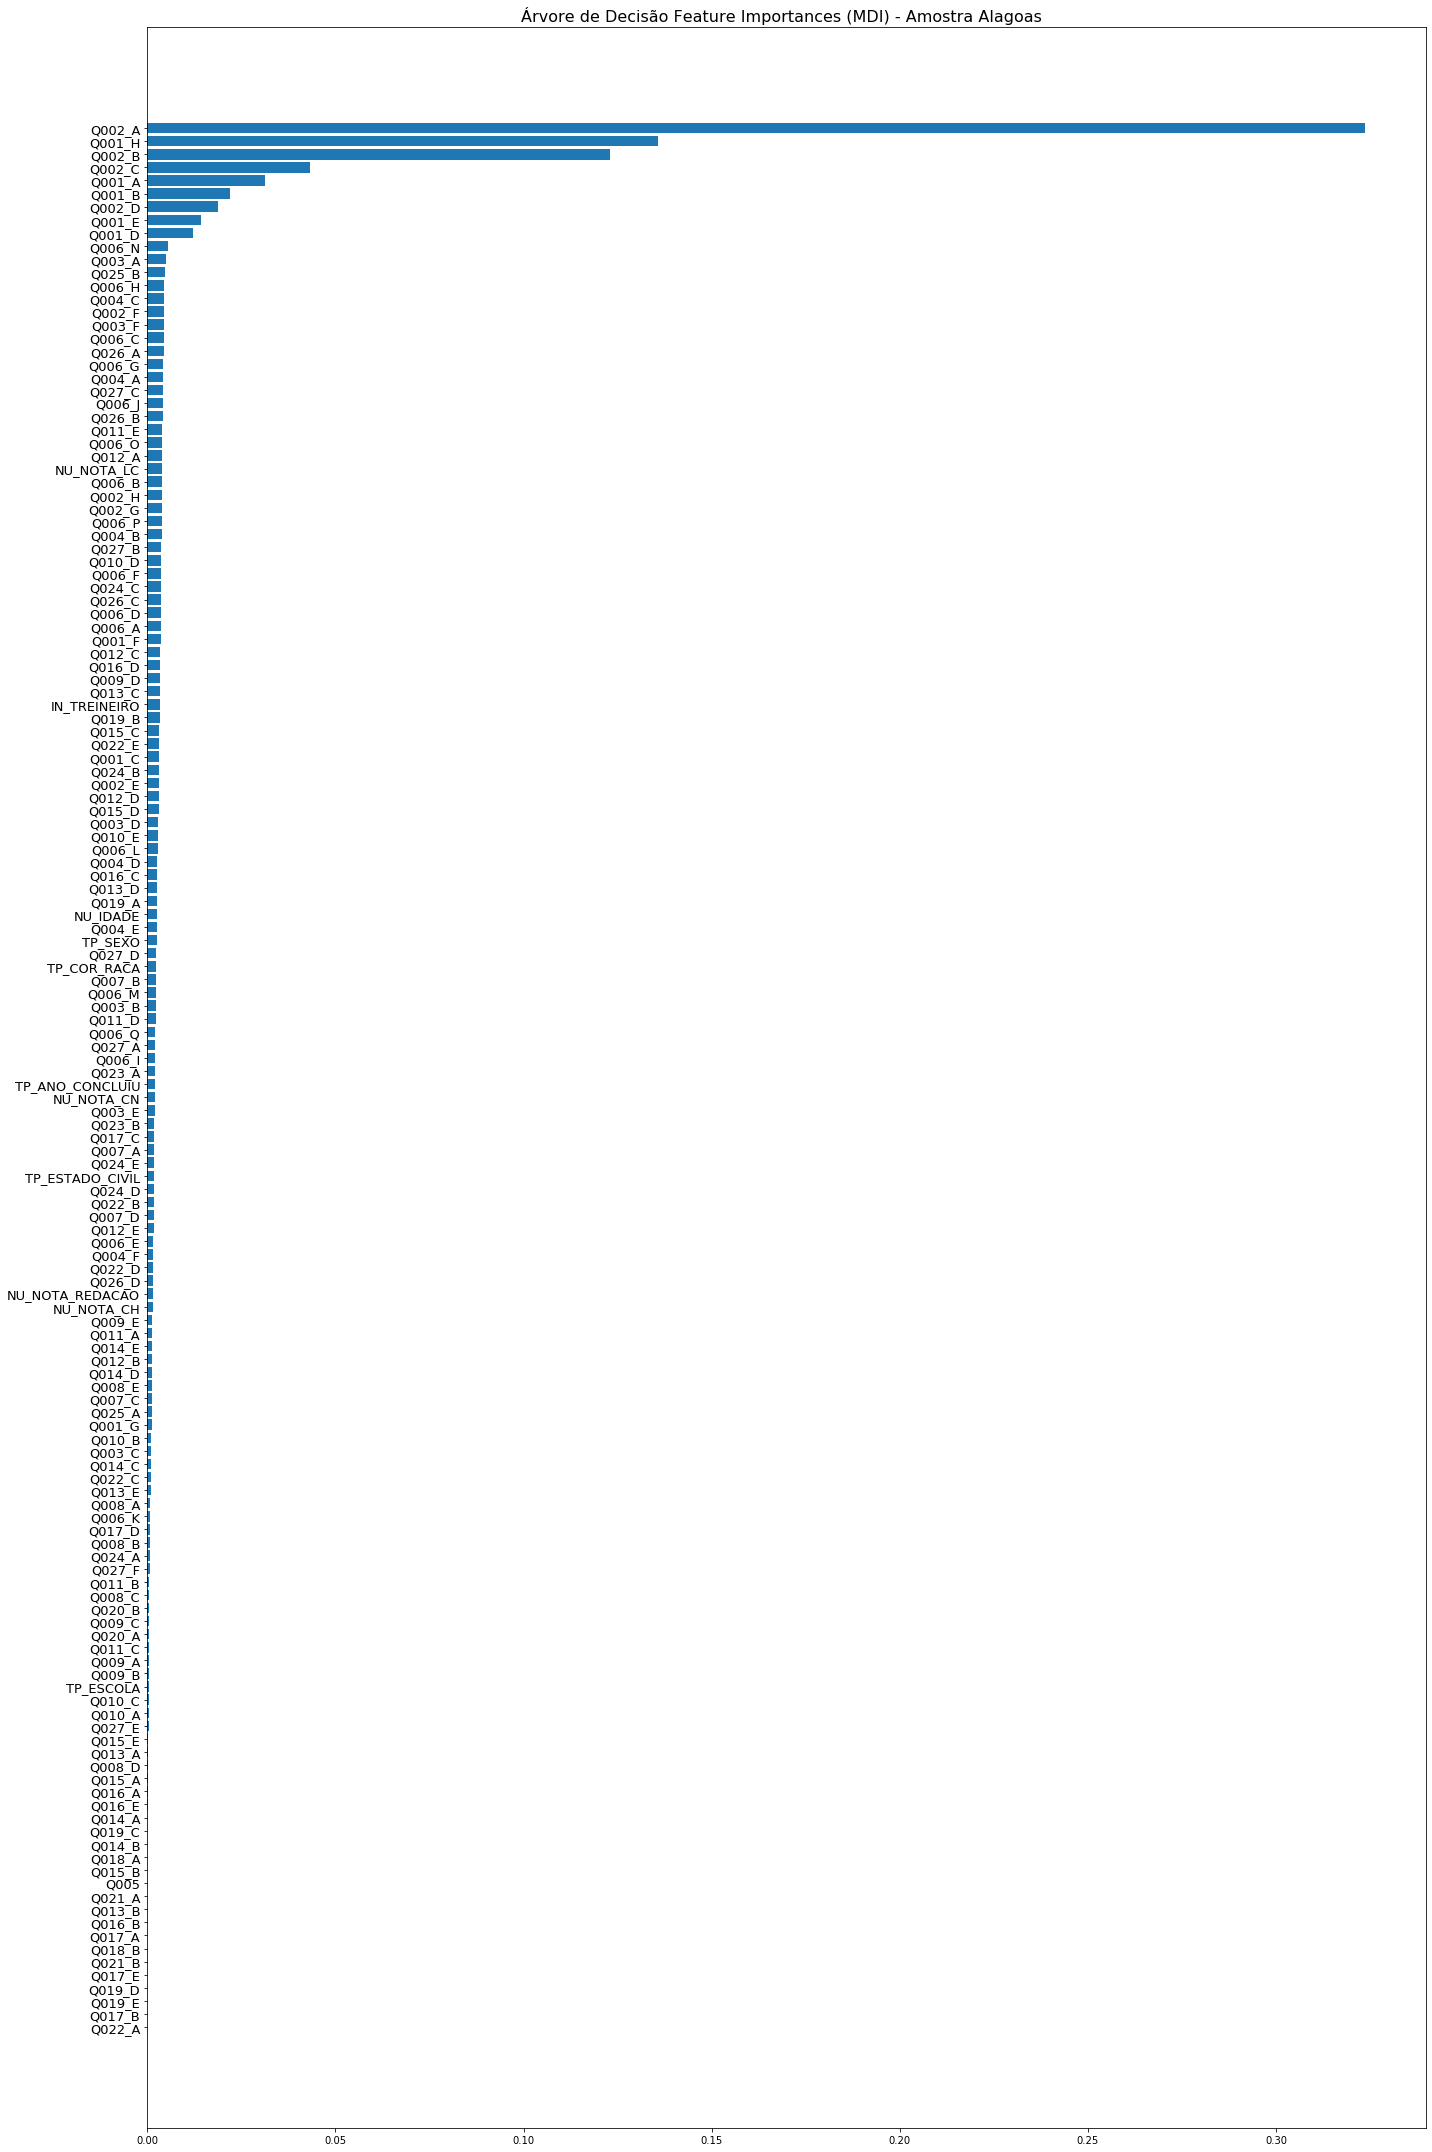

In [25]:
ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 30))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Árvore de Decisão Feature Importances - Amostra Alagoas - Matemática  ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_AL_MT.png', format='png')
plt.show()

In [ ]:
ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)
#feature_names[sorted_idx]
sorted_idx = tree_feature_importances.argsort()
features_importance = zip(tree_feature_importances, feature_names)

for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

# Permutation Importances - Random Forest - Alagoas

TypeError: set_ylabel() missing 1 required positional argument: 'ylabel'

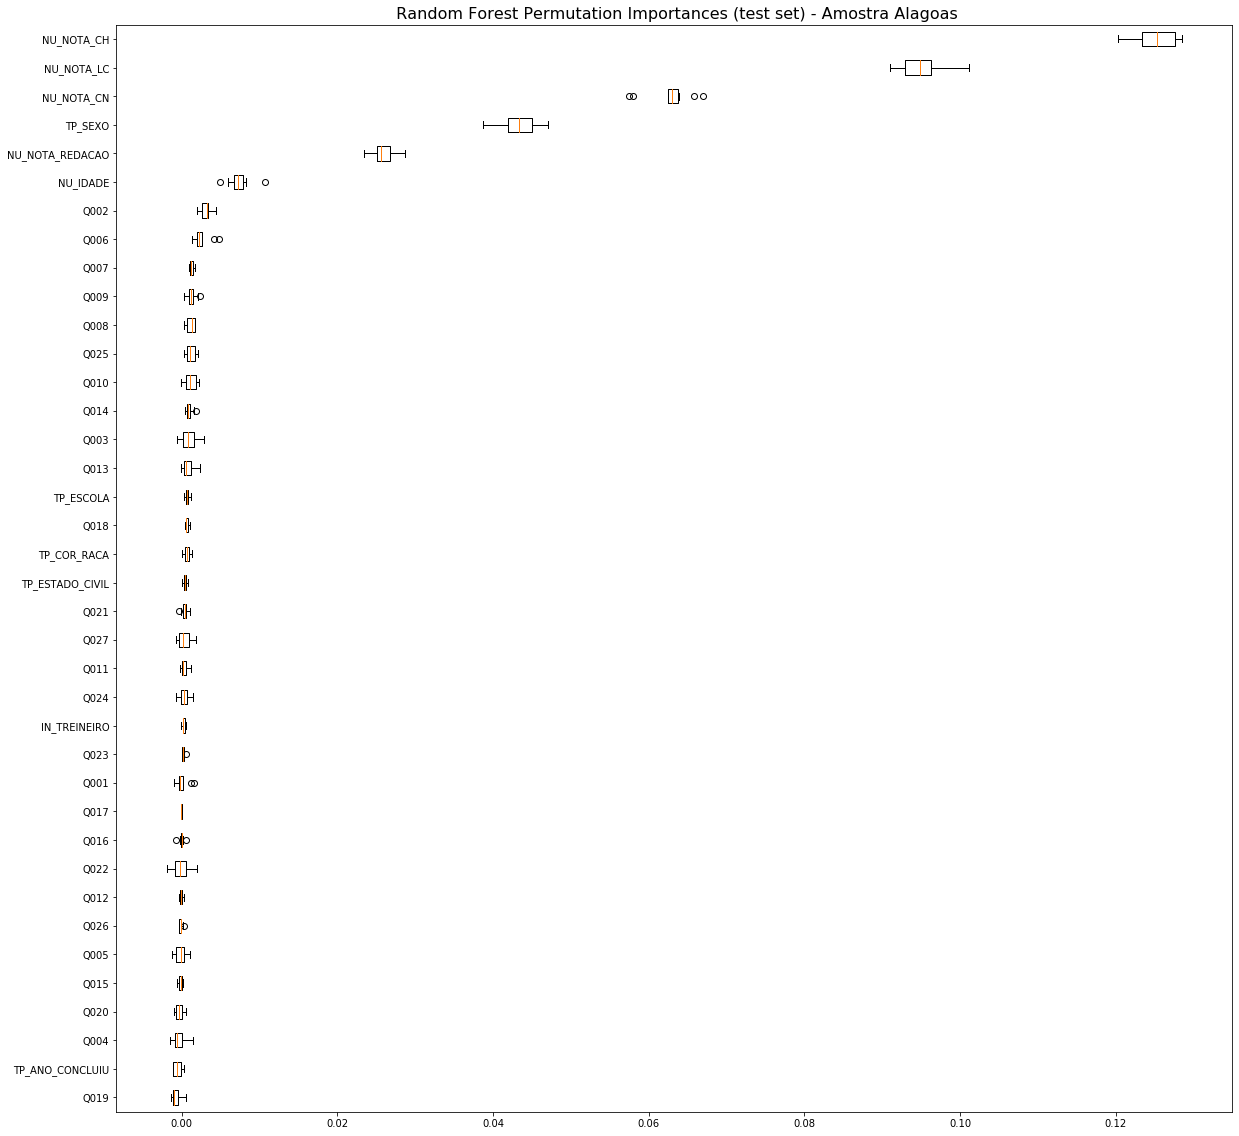

In [28]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Random Forest Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel(fontsize = 13)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_RF_MT_AL.png', format='png')

plt.show()

# Permutation Importances - Decision Tree - Alagoas

TypeError: set_ylabel() missing 1 required positional argument: 'ylabel'

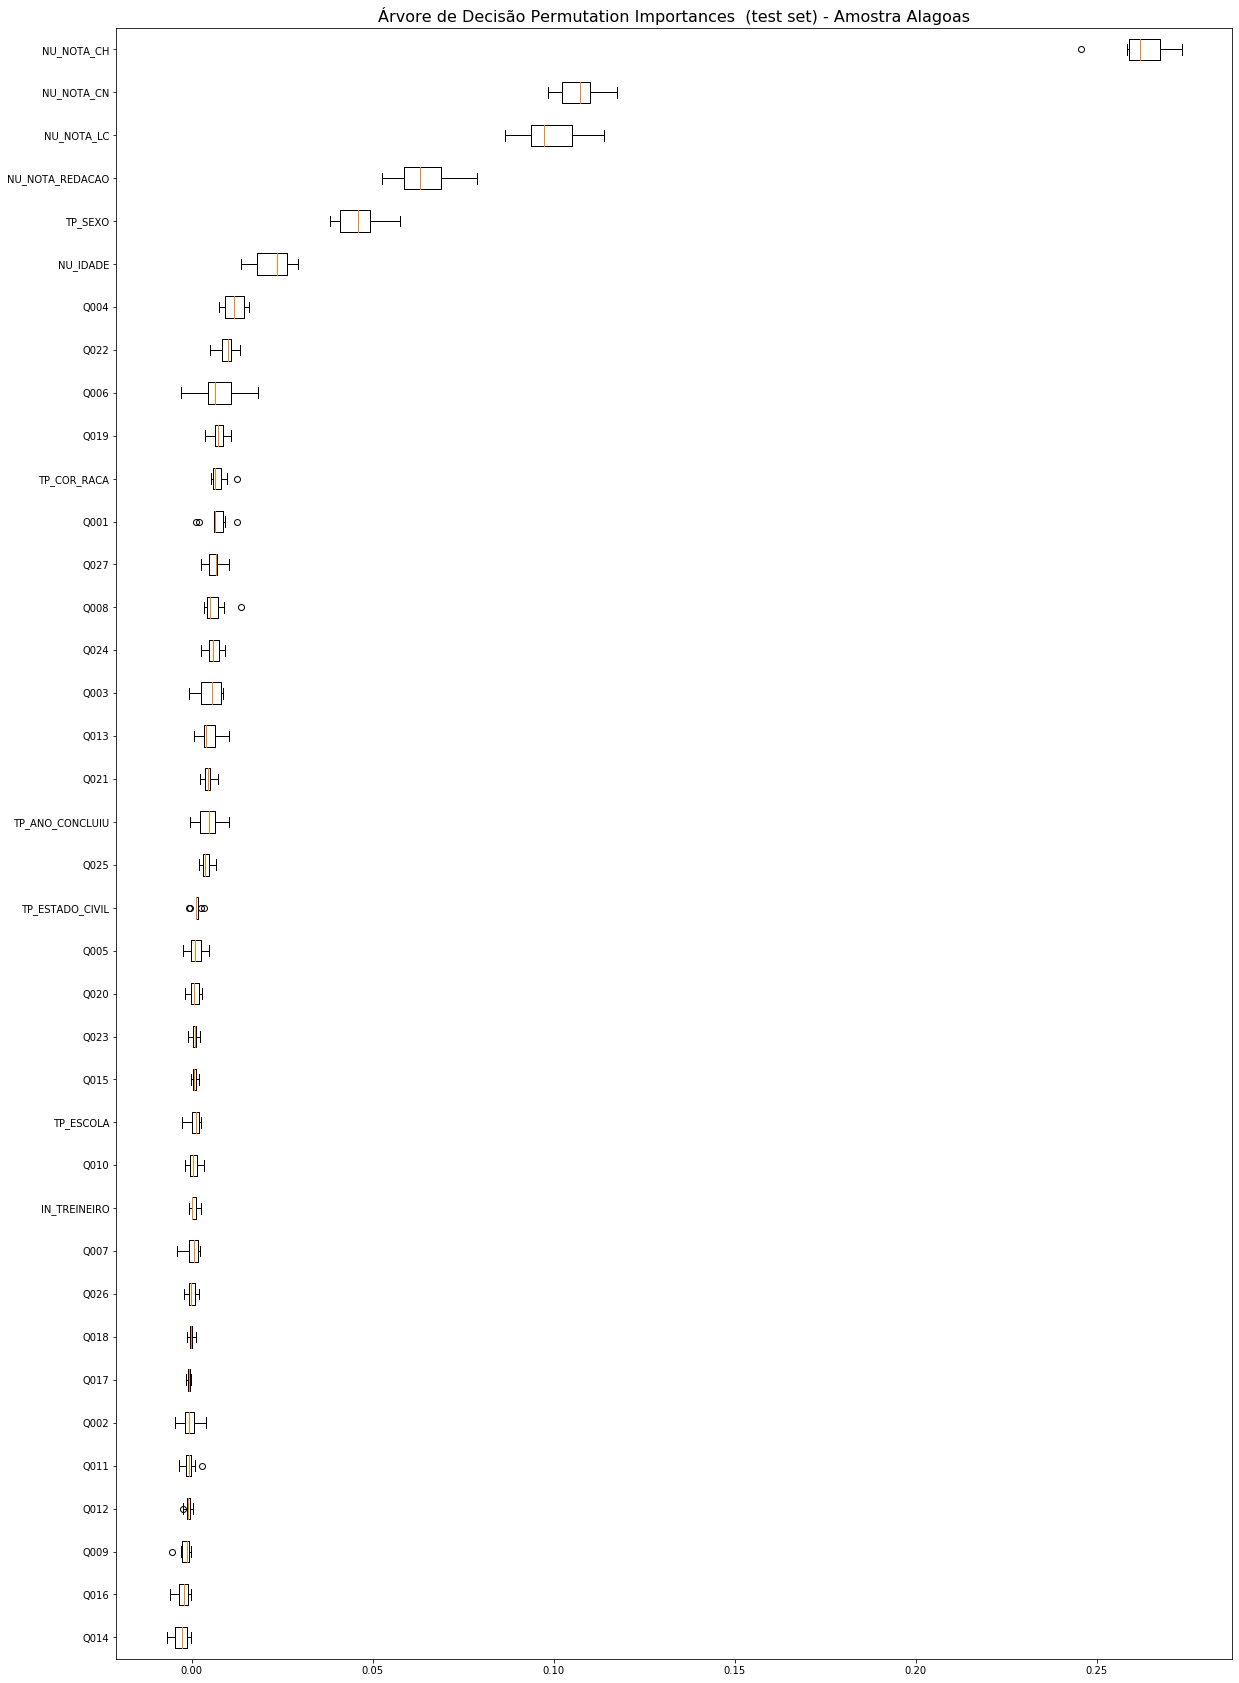

In [30]:
result_dt = permutation_importance(dtree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result_dt.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 30))
ax.boxplot(result_dt.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Árvore de Decisão Permutation Importances  (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel(fontsize = 13)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_Dtree_AL.png', format='png')

plt.show()

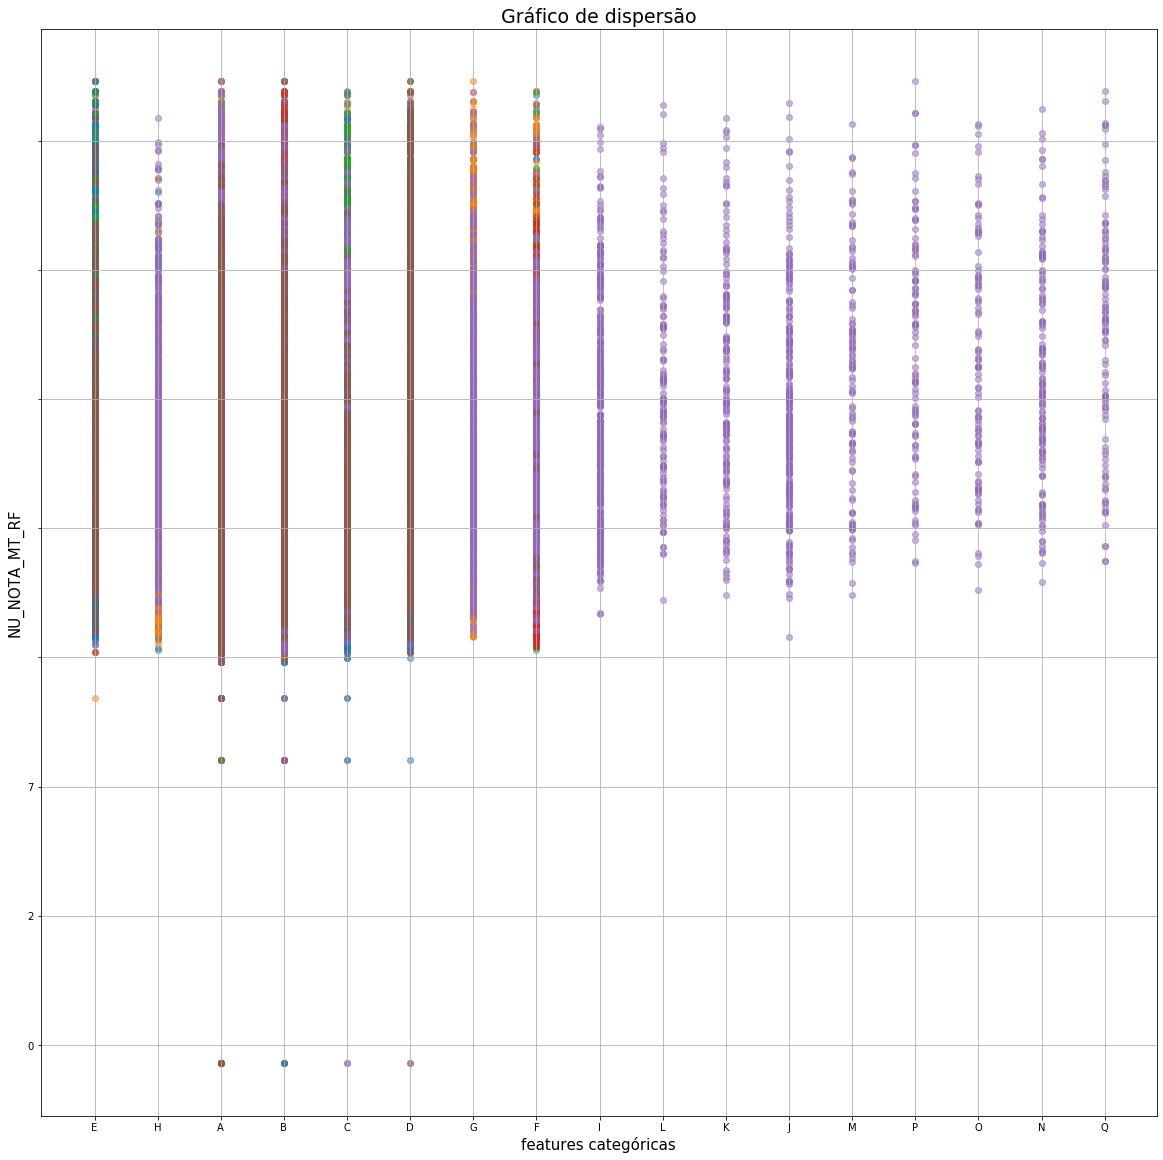

In [35]:


y_ticks = np.arange(0,len(feature_names))
#c = np.random.randint(1, 20, size=N)
fig, ax = plt.subplots(figsize=(20, 20))
labels = categorical_features
for l  in  labels:  
    ax.scatter(X_test[l], df_resposta['NU_NOTA_MT_Random Forest'], alpha=0.5)
    ax.set_yticklabels(l)
  #  ax.set_yticks(y_ticks)
    
plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)

plt.savefig('imagens/graficoDispersao.png', format='png')
plt.show()

In [113]:
from time import gmtime, strftime
df_metricas
#valores
print("tempo de processamento em minutos:" , (round(elapsed_time/60, 2)))
print(time.time() )




tempo de processamento em minutos: 8.99
1587849454.7471185


In [123]:
#df_resposta.sort_index(inplace= True)
df_resposta.sort_values(by='NU_NOTA_MT', inplace = True)
df_resposta

,NU_INSCRICAO,NU_NOTA_MT,NU_NOTA_MT_Random Forest,NU_NOTA_MT_Regressão Linear,NU_NOTA_MT_Rede Neural,NU_NOTA_MT_Árvore de decisão
38470,180011090787,0.0,320.88,368.904458,492.857858,445.6
14046,180008766597,0.0,436.19,374.507918,541.028103,429.5
50395,180012184190,0.0,485.11,513.666849,548.887518,514.4
22686,180007519102,0.0,368.58,350.851999,470.231351,429.1
44244,180011344996,361.2,514.50,533.929467,499.979182,521.7
...,...,...,...,...,...,...
40045,180011021843,904.0,743.53,655.499689,752.562476,755.1
63249,180012914250,906.0,764.88,726.046851,787.212515,769.3
38975,180010706830,925.8,627.58,621.843132,545.033304,685.5
55576,180013033911,949.0,653.92,666.319668,665.978163,717.6


In [127]:
x_ticks = np.arange(0, len(df_resposta['NU_INSCRICAO']))
x_ticks


array([    0,     1,     2, ..., 19379, 19380, 19381])

In [ ]:
labels = ['NU_NOTA_MT','Random Forest', 'Regressão Linear', 'Rede Neural', 'Árvore de decisão']
colunas = ['NU_NOTA_MT', 'NU_NOTA_MT_Random Forest',
       'NU_NOTA_MT_Regressão Linear', 'NU_NOTA_MT_Rede Neural',
       'NU_NOTA_MT_Árvore de decisão']


fig, ax = plt.subplots(figsize=(20, 20))

for label, coluna in zip(labels, colunas):
    ax.plot(df_resposta[coluna],x_ticks, label = label)


plt.xlabel('candidatos')
plt.ylabel('Notas de Matemática')
plt.title("Notas preditivas")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Média de votos em filmes no TMBD 5000')

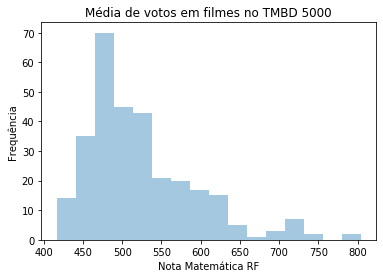

In [36]:
ax = sns.distplot(df_resposta['NU_NOTA_MT_RF'], norm_hist= False, kde= False)
ax.set(xlabel='Nota Matemática RF', ylabel='Frequência')
ax.set_title('')

# Plotando a distribuíção das notas

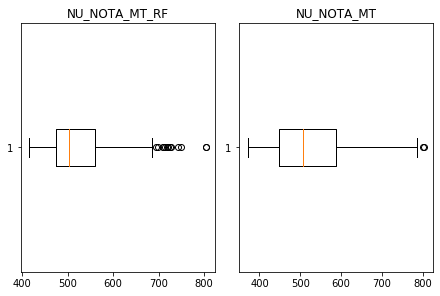

In [39]:
fig, axs = plt.subplots(1, 2, figsize=[6,4], constrained_layout=True)

idx=['NU_NOTA_MT_RF', 'NU_NOTA_MT']
for ax, i in zip(axs, ['NU_NOTA_MT_RF', 'NU_NOTA_MT']):
    ax.set_title(i)
    ax.boxplot(df_resposta[i], vert=False)

#plt.savefig('imagens/featuresImportances.png', format='png')

plt.show()


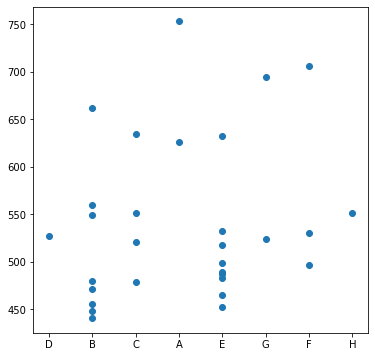

In [56]:
import matplotlib as mpl
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)
fig, ax = plt.subplots(figsize=(6, 6))
#print(X_test.sort_values('Q001')['Q001'])
ax.scatter(, df_resposta['NU_NOTA_MT_Random Forest'])

In [2]:
letras = ['A', 'B', 'C',  'D',
                 'E',
                 'F',
                 'G',
                 'H',
                 'I',
                 'J',
                 'K',
                 'L',
                 'M',
                 'N',
                 'O',
                 'P',
                 'Q']

In [39]:
sns.catplot(x="Q001", y="NU_NOTA_MT_Random Forest", data=df);

NameError: name 'df' is not defined

KeyError: 'NU_NOTA_MT_Random Forest'

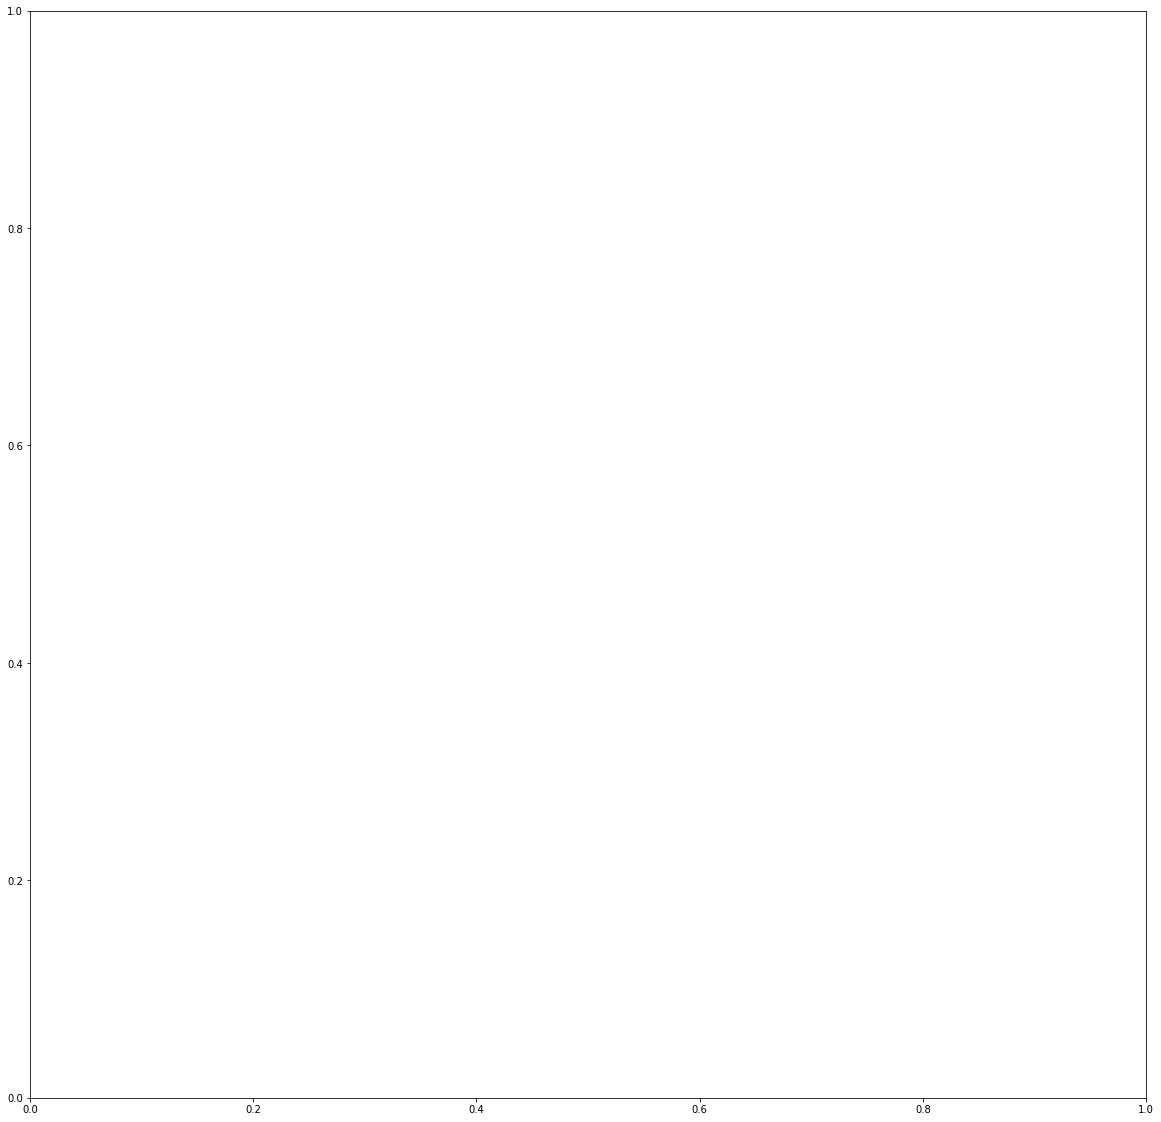

In [117]:
y_ticks = np.arange(0, len(categorical_features))
cmap = plt.cm.RdYlBu
fig, ax = plt.subplots(figsize=(20, 20))
for i in categorical_features:
    ax.scatter(X_test[i], df_resposta['NU_NOTA_MT_Random Forest'], label = i, cmap = cmap)
#ax.set_yticklabels('Q001')
#ax.set_yticks(y_ticks)

plt.grid(True)
plt.xlabel('features categóricas', fontsize=15)
plt.ylabel('NU_NOTA_MT_RF', fontsize=15)
plt.title('Gráfico de dispersão', fontsize=19)
plt.legend()
plt.show()

# Salvar a figura a qualquer momento

In [ ]:
fig = plt.gcf()
plt.show()
fig.savefig('teste.png', format='png')